# Practice 7.2

# Setup

In [31]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from plotnine import *

In [10]:
df = pd.read_csv("/content/sample_data/AmesHousing.csv")

X = df.drop(columns=["SalePrice", "Order", "PID"], errors="ignore")
y = df["SalePrice"]

## Practice 1

OLS RMSE: 29730.71
Ridge RMSE (λ=1): 28871.92


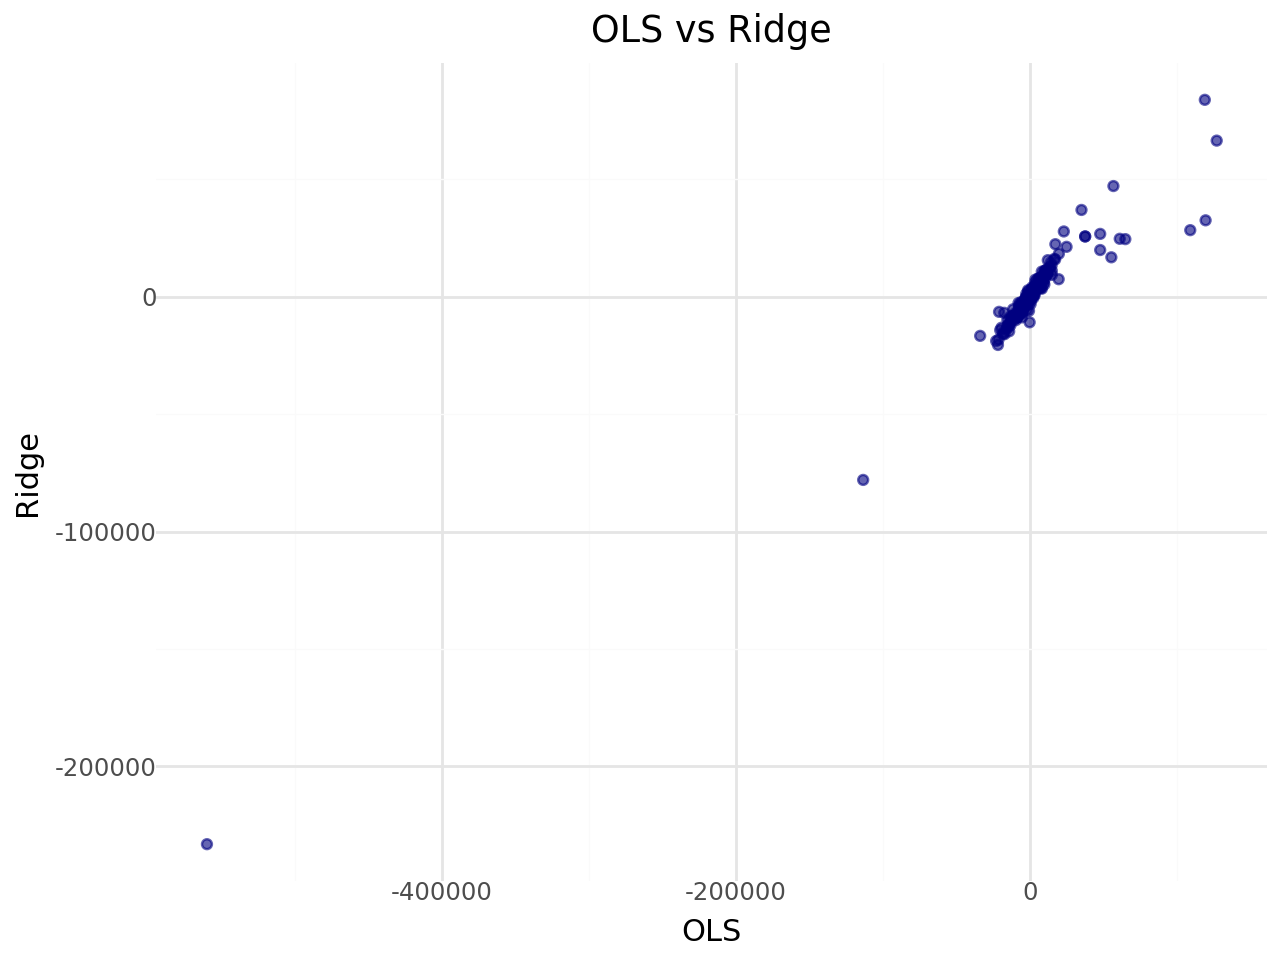

In [13]:
df = df.loc[:, df.isna().sum() < 100]
df = df.dropna()

X = df.drop(["SalePrice", "Order", "PID"], axis=1)
y = df["SalePrice"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
     make_column_selector(dtype_include=object))])

ols_pipe = Pipeline([
    ("pre", preprocess),
    ("ols", LinearRegression())])

ridge_pipe = Pipeline([
    ("pre", preprocess),
    ("ridge", Ridge(alpha=1))])

rmse_ols = (-cross_val_score(ols_pipe, X, y, cv=5,
                              scoring="neg_root_mean_squared_error")).mean()
rmse_ridge = (-cross_val_score(ridge_pipe, X, y, cv=5,
                                scoring="neg_root_mean_squared_error")).mean()

print("OLS RMSE:", round(rmse_ols, 2))
print("Ridge RMSE (λ=1):", round(rmse_ridge, 2))

ols_pipe.fit(X, y)
ridge_pipe.fit(X, y)

b_ols = ols_pipe.named_steps["ols"].coef_
b_ridge = ridge_pipe.named_steps["ridge"].coef_

coefs = pd.DataFrame({
    "OLS": b_ols,
    "Ridge": b_ridge})

(ggplot(coefs, aes(x="OLS", y="Ridge"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="OLS vs Ridge",
        x="OLS",
        y="Ridge")
 + theme_minimal())


## Practice 2

In [17]:
df = df.loc[:, df.isna().sum() < 100]
df = df.dropna()

X = df.drop(["SalePrice", "Order", "PID"], axis=1)
y = df["SalePrice"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
     make_column_selector(dtype_include=object))])

ridge_pipe = Pipeline([
    ("pre", preprocess),
    ("ridge", Ridge())])

param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1)

ridge_cv.fit(X, y)

best_lambda = ridge_cv.best_params_["ridge__alpha"]
best_rmse = -ridge_cv.best_score_

print(best_lambda)
print(round(best_rmse, 2))

10
28633.51


## Practice 3

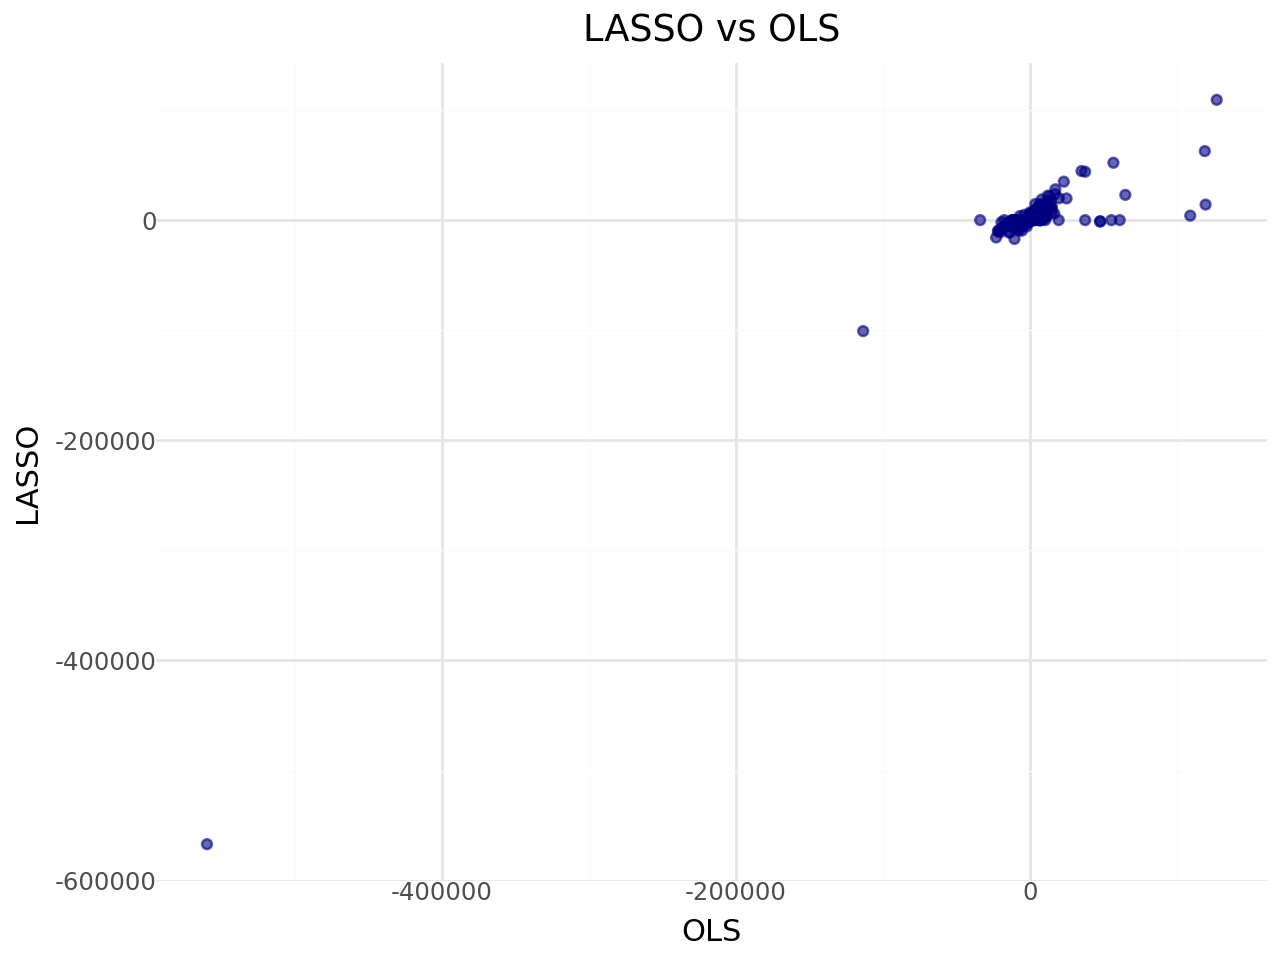

In [26]:
lasso_pipe = Pipeline([
    ("pre", preprocess),
    ("lasso", Lasso(alpha=10, max_iter=50000))])

lasso_pipe.fit(X, y)

coef_lasso = lasso_pipe.named_steps["lasso"].coef_

coef_df = pd.DataFrame({
    "OLS": b_ols,
    "LASSO": coef_lasso})

(ggplot(coef_df, aes(x="OLS", y="LASSO"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="LASSO vs OLS",
        x="OLS",
        y="LASSO")
 + theme_minimal())

## Practice 4

best α: 0.01, best l1_ratio: 0.5, RMSE: 28632.34


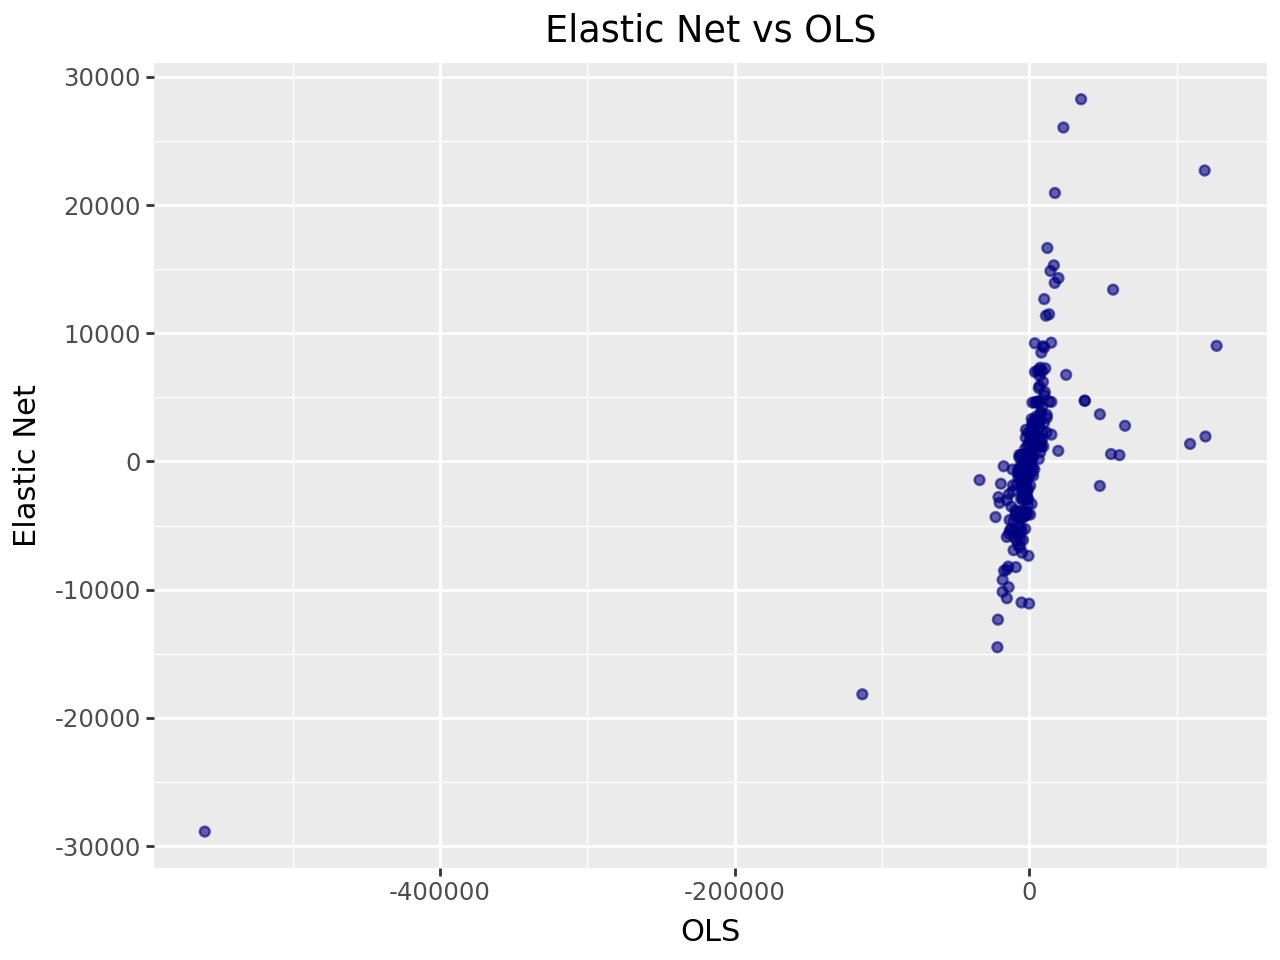

In [32]:
elastic_pipe = Pipeline([
    ("pre", preprocess),
    ("enet", ElasticNet(max_iter=50000))])

alphas = [0.001, 0.01, 0.1, 1, 10]
l1s = [0.1, 0.5, 0.9]

scores = []
for a in alphas:
    for l1 in l1s:
        elastic_pipe.set_params(enet__alpha=a, enet__l1_ratio=l1)
        rmse = (-cross_val_score(elastic_pipe, X, y, cv=5,
                                 scoring="neg_root_mean_squared_error")).mean()
        scores.append((a, l1, rmse))

best_a, best_l1, best_rmse = min(scores, key=lambda x: x[2])
print(f"best α: {best_a}, best l1_ratio: {best_l1}, RMSE: {round(best_rmse,2)}")

elastic_pipe.set_params(enet__alpha=best_a,
                        enet__l1_ratio=best_l1).fit(X, y)

coef_elastic = elastic_pipe.named_steps["enet"].coef_

coef_df = pd.DataFrame({
    "OLS": b_ols,
    "ElasticNet": coef_elastic})

(ggplot(coef_df, aes(x="OLS", y="ElasticNet"))
 + geom_point(alpha=0.6, color="navy")
 + labs(title="Elastic Net vs OLS",
        x="OLS",
        y="Elastic Net"))